In [3]:
import pysteps.motion as motion
from pysteps import nowcasts
import os
import xarray as xr
from pysteps.utils import conversion, dimension, transformation
# from helper.pre_process_target_input import normalize_data, inverse_normalize_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm


Pysteps configuration file found at: /Users/jan/miniforge3/envs/pysteps/lib/python3.10/site-packages/pysteps/pystepsrc


Use local conda env called 'pysteps'

--> Overview in Freeform 'Data Normalization - Meeting Martin 15.10.2024'

--> Explanation video in icloud note 'Normalization / transformation precipitation data'

Implementing STEPS nowcast:
https://pysteps.readthedocs.io/en/stable/auto_examples/plot_steps_nowcast.html

my first nowcast colab:
https://colab.research.google.com/github/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb#scrollTo=CeCVjlNq3-jd
--> Transforming data from long tail to log-norm using 'dBR' unit is explained! using pysteps.utils.transformation.dB_transform()

In [4]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
file_name_radolan = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, file_name_radolan)
load_path_dem = '/Users/jan/Programming/geo_data/static/dem_benchmark_dataset_1200_1100.zarr'

print(f'loading from: {load_path}')

loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [5]:
dataset = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
dataset_unclipped = dataset.copy()
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
dataset = dataset.squeeze()
# Set all negative values of the dataset to 0
data_min = dataset.min(skipna=True, dim=None).RV_recalc.values
if data_min < -0.1:
    raise ValueError(f'The min value of the dataset is {data_min}, which is below the threshold of -0.1')
# dataset = dataset.where(dataset >= 0, 0) 
dataset = dataset.where((dataset >= 0) | np.isnan(dataset), 0)
# The where function keeps values where the condition is True and replaces the rest (where it's False) with the value specified, in this case 0.
print(f'min val in dataset is {dataset.min(skipna=True, dim=None).RV_recalc.values}')

min val in dataset is 0.0


In [6]:
data = dataset['RV_recalc'].values
log_data = np.log1p(data)
log_mean = np.nanmean(log_data)
log_std = np.nanstd(log_data)
data_plotting = data
data_plotting[data_plotting>100] = 100 #  Cut off all entries that have > 100mm rain
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')

Min val imn data_plotting: 0.0


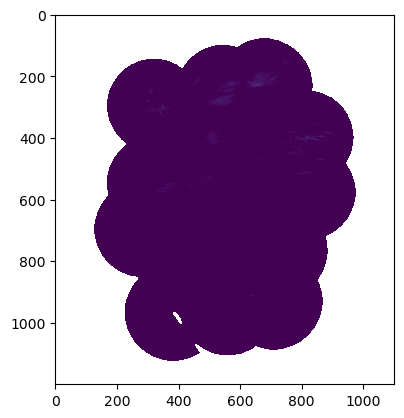

In [7]:
plt.imshow(data[50,:,:])
plt.show()

### Original Data

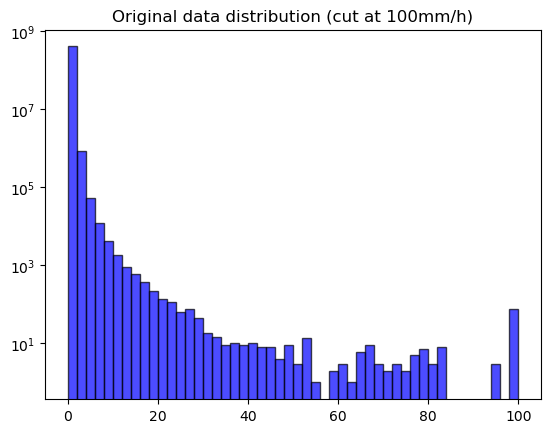

In [8]:
plt.hist(data_plotting.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Original data distribution (cut at 100mm/h)')
plt.show()

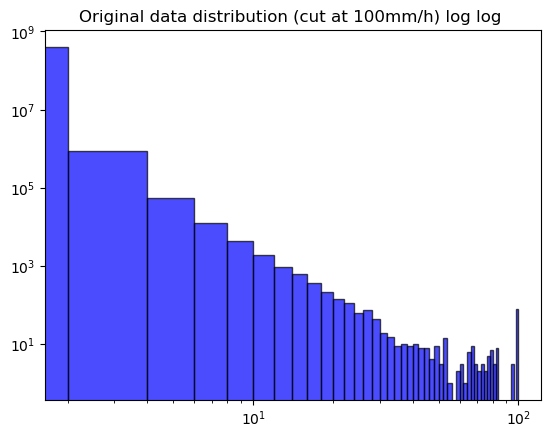

In [9]:

plt.hist(data_plotting.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.title('Original data distribution (cut at 100mm/h) log log ')
plt.show()

### DB Transformation
The histogram shows that rain rate values have a non-Gaussian and asymmetric distribution that is bounded at zero. Also, the probability of occurrence decays extremely fast with increasing rain rate values (note the logarithmic y-axis).


For better performance of the motion estimation algorithms, we can convert the rain rate values (in mm/h) to a more log-normal distribution  of rain rates by applying the following logarithmic transformation:

\begin{equation}
R\rightarrow
\begin{cases}
    10\log_{10}R, & \text{if } R\geq 0.1\text{mm h$^{-1}$} \\
    -15,          & \text{otherwise}
\end{cases}
\end{equation}

The transformed precipitation corresponds to logarithmic rain rates in units of dBR. The value of −15 dBR is equivalent to assigning a rain rate of approximately 0.03 mm h$^{−1}$ to the zeros. 

In [10]:
# Using the db transformation of PySTEPS
 # For some reason pysteps seems to change shit in data_plotting
data_db_transformed = transformation.dB_transform(data_plotting.copy(), threshold=0.1, zerovalue=-15.0)[0] #This returns a tuple with metatdata, where first entry is actual data
data_db_transformed_flattened = data_db_transformed.flatten()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')

Min val imn data_plotting: 0.0


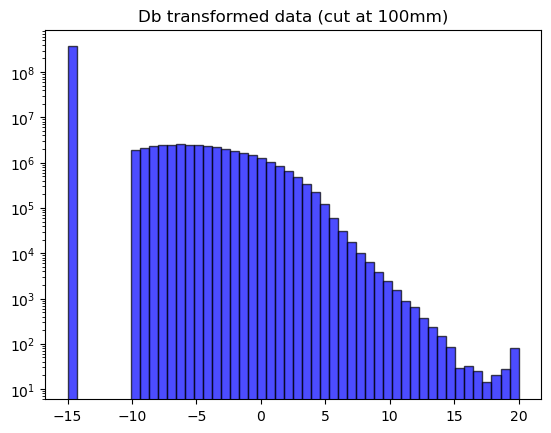

In [11]:
plt.hist(data_db_transformed.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Db transformed data (cut at 100mm)')
plt.show()

#### Reproduce pystep's DB transformation:

In [12]:
# Rebuilding Pysteps db normalization
def my_db_normalization(data, threshold=0.1, zerovalue=-15.0):
    zeros = data < threshold
    data[~zeros] = 10.0 * np.log10(data[~zeros])
    data[zeros] = zerovalue
    # data_db_transformed = 10.0 * np.log10(1+data)
    return data

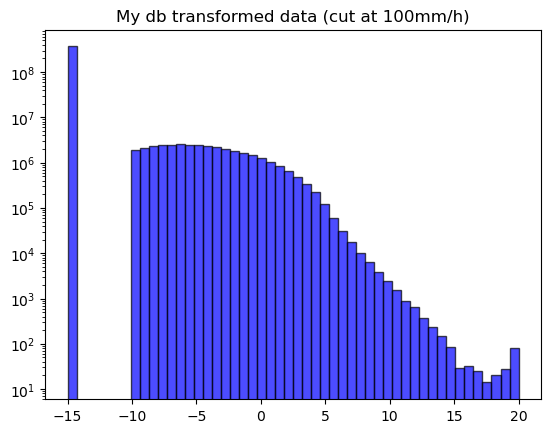

Min val imn data_plotting: 0.0


In [13]:
data_normed = my_db_normalization(data_plotting.copy())
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My db transformed data (cut at 100mm/h)')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')


### Making a better normalization for our model
Let's make something that comes as close to projecting our data to -1 and 1, but which does not have this jump in the beginning.
A crucial point is zero handling. For log10(x) x=0.1 equals -1. So Choosing log 10 and then adding 0.1 to everything to push all zeros up to 0.1 seems like a good idea.

Our upper bounds of the data are cut off at 100 mm/h. log10(100) = 2, So we are not perfectlz between -1 and 1.

### Most simple solution to implement:

In [30]:
# Rebuilding Pysteps db normalization
def log_10_transform(data, add_val=10 ** -1):
    # We choose 10 ** -1 = 0.1 as add val as log10(10**-1) = -1
    data = 1 + np.log10(data + add_val)
    # data_db_transformed = 10.0 * np.log10(1+data)
    return data

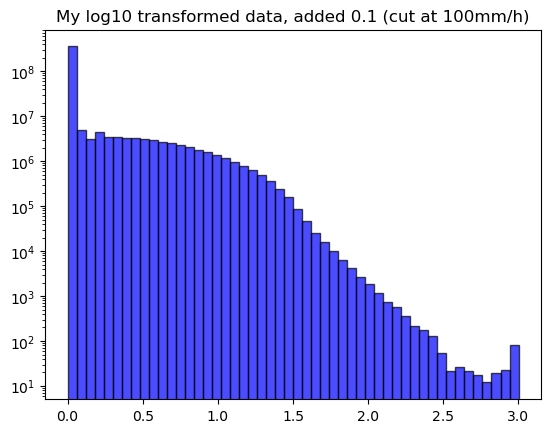

Min val imn data_plotting: 0.0


In [31]:
data_normed = log_10_transform(data_plotting.copy())
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 0.1 (cut at 100mm/h)')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')


#### Adding 0.01 to log10
This is what happens if we add 0.01 instead of 0.1 to to the data. This leads to an over-emphasis of the rain data below 0.1 mm/h in my opinion.

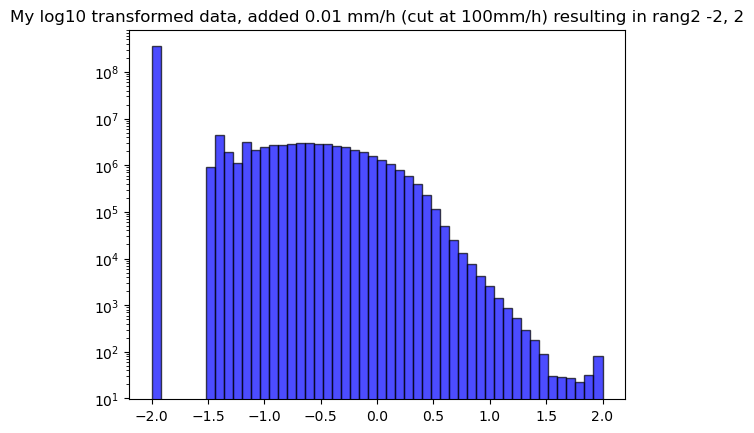

Min val imn data_plotting: 0.0


In [16]:
data_normed = log_10_transform(data_plotting.copy(), add_val=0.01)
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 0.01 mm/h (cut at 100mm/h) resulting in rang2 -2, 2')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')


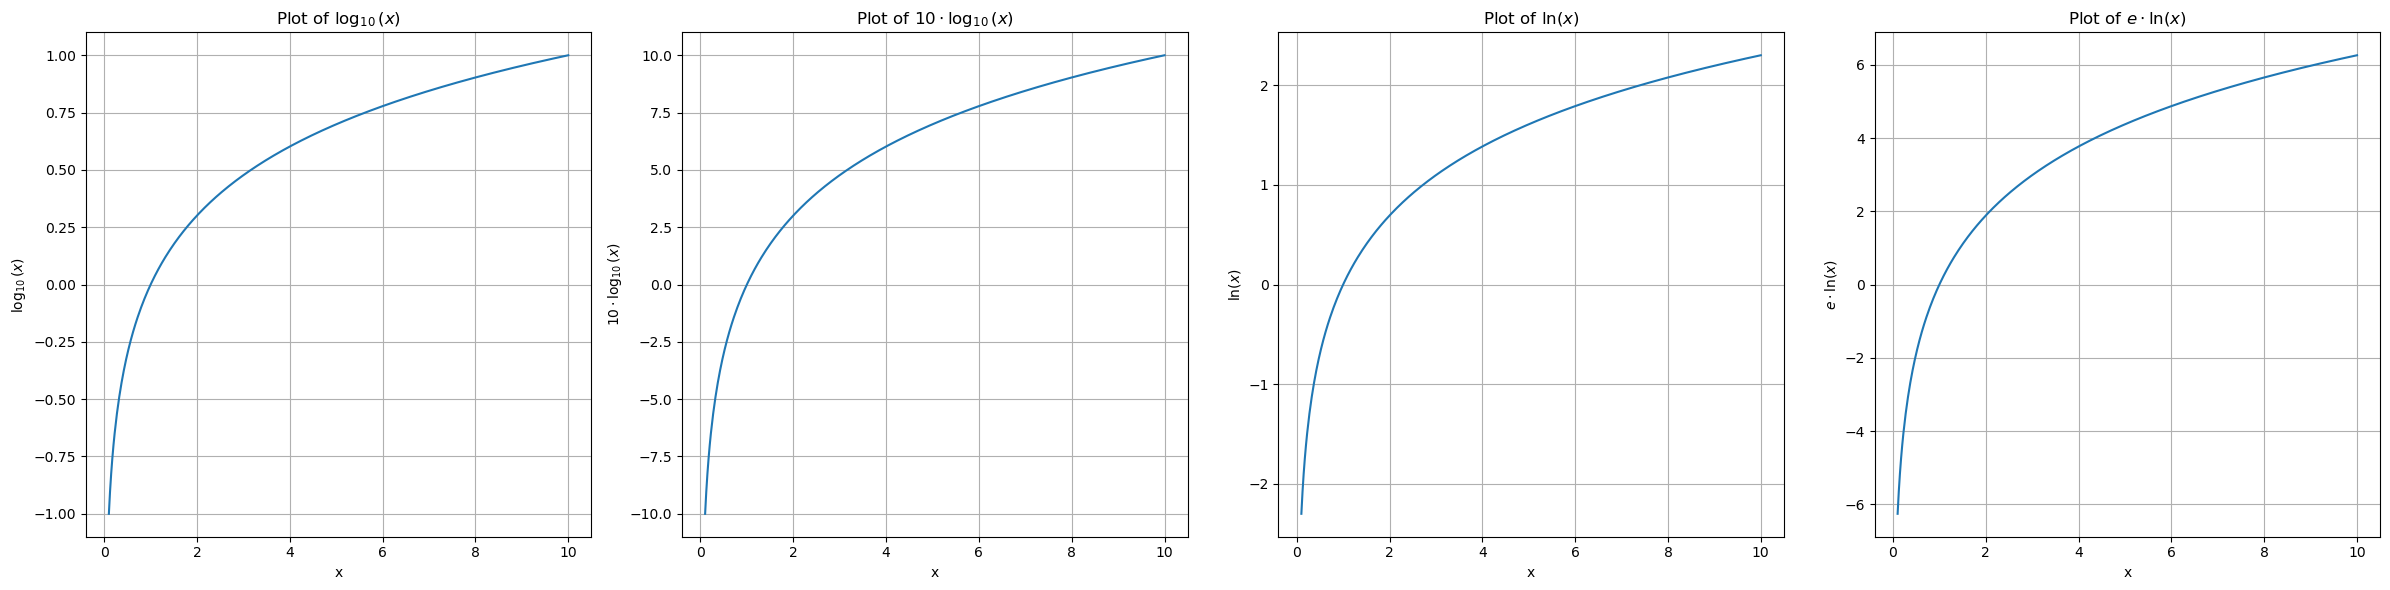

In [17]:

# Generate x values
x = np.linspace(0.1, 10, 400)  # Avoid log(0) by starting from 0.1

# Calculate the values for each function
y_log10 = np.log10(x)
y_10log10 = 10.0 * np.log10(x)
y_ln = np.log(x)
y_e_ln = np.exp(1) * np.log(x)

# Generate 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Plot log10(x)
axs[0].plot(x, y_log10, label=r'$\log_{10}(x)$')
axs[0].set_title(r'Plot of $\log_{10}(x)$')
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$\log_{10}(x)$')
axs[0].grid(True)

# Plot 10 * log10(x)
axs[1].plot(x, y_10log10, label=r'$10 \cdot \log_{10}(x)$')
axs[1].set_title(r'Plot of $10 \cdot \log_{10}(x)$')
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$10 \cdot \log_{10}(x)$')
axs[1].grid(True)

# Plot ln(x)
axs[2].plot(x, y_ln, label=r'$\ln(x)$')
axs[2].set_title(r'Plot of $\ln(x)$')
axs[2].set_xlabel('x')
axs[2].set_ylabel(r'$\ln(x)$')
axs[2].grid(True)

# Plot e * ln(x)
axs[3].plot(x, y_e_ln, label=r'$e \cdot \ln(x)$')
axs[3].set_title(r'Plot of $e \cdot \ln(x)$')
axs[3].set_xlabel('x')
axs[3].set_ylabel(r'$e \cdot \ln(x)$')
axs[3].grid(True)

# Show all plots
plt.tight_layout()
plt.show()


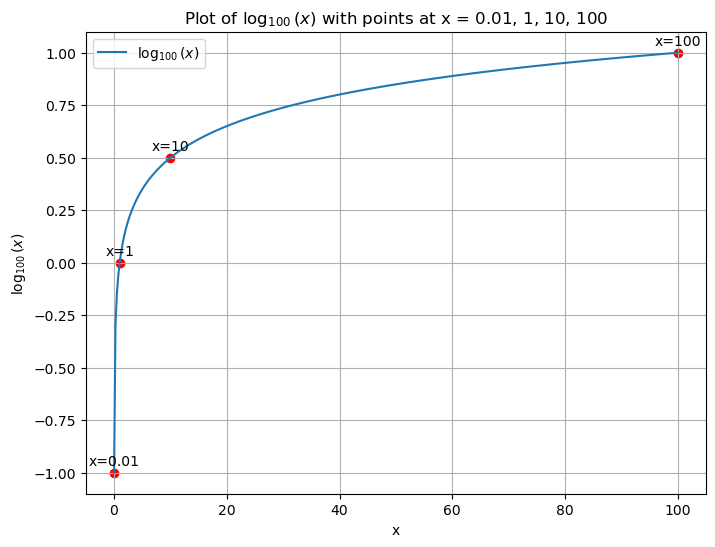

In [18]:
# Generate values for x in the range 0.01 to 100
x = np.linspace(0.01, 100, 400)

# Calculate log100(x), equivalent to log(x) / log(100)
y_log100 = np.log(x) / np.log(100)

# Define the points to mark
points_x = [0.01, 1, 10, 100]
points_y = np.log(points_x) / np.log(100)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x, y_log100, label=r'$\log_{100}(x)$')

# Mark specific points on the plot
plt.scatter(points_x, points_y, color='red')
for i, txt in enumerate(points_x):
    plt.annotate(f'x={txt}', (points_x[i], points_y[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Add labels and title
plt.title(r'Plot of $\log_{100}(x)$ with points at x = 0.01, 1, 10, 100')
plt.xlabel('x')
plt.ylabel(r'$\log_{100}(x)$')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


#### Log100 normalization
Maybe - in order to get the data between -1 and 1 it is best to use log100? As our upper bound is x=100 this would correspond to y=1
At the same time if we want to our lower bound to be y=-1, this would mean that we'd have to go for 0.01 as a lower bound. 
--> This puts too much emphasis on the bins for rain that is below 0.1, which is not that important to us.

In [19]:
def log100_transform(data, add_val=100**-1):
    # We choose 100 ** -1 = 0.1 as add val as log100(100**-1) = -1
    data = np.log(data + add_val) / np.log(100)
    # data_db_transformed = 10.0 * np.log10(1+data)
    print(f'mean data {np.mean(data)}')
    return data

mean data nan


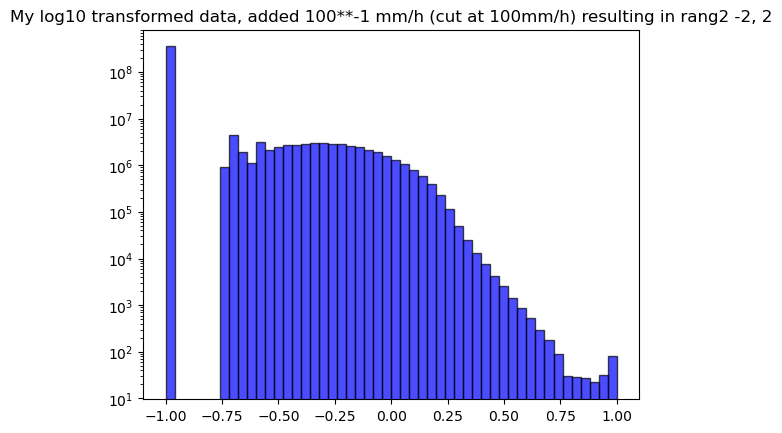

Min val imn data_plotting: 0.0


In [20]:
data_normed = log100_transform(data_plotting.copy())
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 100**-1 mm/h (cut at 100mm/h) resulting in rang2 -2, 2')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')


### Clipping data, choose good base for log, adding upper and lower clips later
- First clip the data say between 0.1 and 100. Everything that is above or below these bounds gets treated seperately
- Choose a good base for the log, such that the data between the bounds gets projected as well as possible between the bounds, as close to lognormal distribution as possible
- All the values above or below the bounds, either get an arbitrary value in the distribution for the input of the network - for the target which is binned all clipped values get into a certain class

In [21]:
# We work with the unclipped data 'data' now
data = dataset_unclipped['RV_recalc'].values
data_unclipped = data.copy()
print(f'min val in data_unclipped is {np.nanmin(data_unclipped)}'
      f' and max val in data_unclipped is {np.nanmax(data_unclipped)}')

min val in data_unclipped is -2.842170943040401e-14 and max val in data_unclipped is 650.010009765625


### This is lowest hanging fruit
Simply modify the normalization to log10 and add 0.1, leave away z-norm

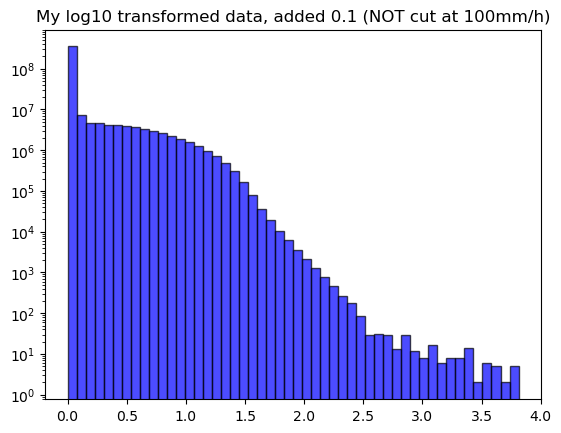

Min val in data_plotting: 0.0


In [27]:
data_normed = log_10_transform(data_unclipped.copy())
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 0.1 (NOT cut at 100mm/h)')
plt.show()
print(f'Min val in data_plotting: {np.nanmin(data_plotting)}')

We can also do the log10 normalization first and subsequently do z-normalization

In [23]:
def z_norm(x):
    return (x / np.std(x)) - np.mean(x)

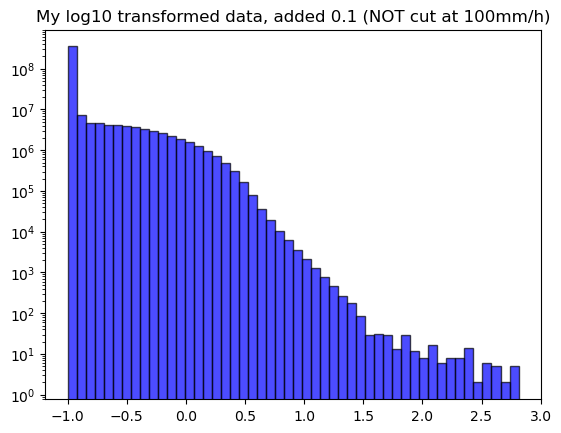

Min val in data_plotting: 0.0


In [24]:
data_normed_and_z_normed = z_norm(data_normed)
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 0.1 (NOT cut at 100mm/h)')
plt.show()
print(f'Min val in data_plotting: {np.nanmin(data_plotting)}')

In [40]:
def log10_clipping(
        data,
        lower_bound=0.1,
        upper_bound=100,
        low_data_y_value = -1.25, #in unshifted distribution
        large_data_y_value = 2.25,
        shift = True
):

    data = data.copy()
    smaller_than_lower_bound = data < lower_bound
    larger_than_upper_bound = data > upper_bound
    within_bounds = ~ (smaller_than_lower_bound | larger_than_upper_bound)
    
    data[within_bounds] = np.log10(data[within_bounds])
    
    data[smaller_than_lower_bound] = low_data_y_value
    data[larger_than_upper_bound] = large_data_y_value
    
    if shift:
        data = data  - low_data_y_value
    
    return data
    

### This looks good

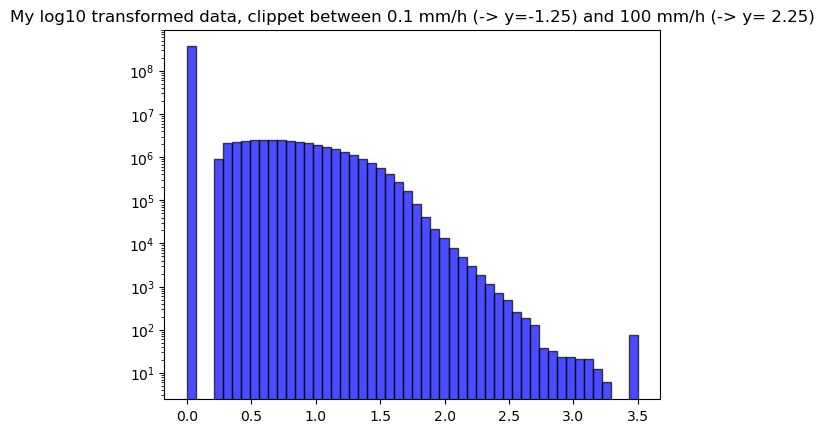

Min val imn data_plotting: 0.0


In [41]:
data_normed = log10_clipping(data_unclipped)
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, clippet between 0.1 mm/h (-> y=-1.25) and 100 mm/h (-> y= 2.25)')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')

## This looks BEST
Let's try the same with log100 not to exceed 1 as a range)

In [208]:
def log100_clipping(
        data,
        lower_bound=0.1,
        upper_bound=100,
        low_data_y_value = -0.6,
        large_data_y_value = 1.1
):
    
    data = data.copy()
    smaller_than_lower_bound = data < lower_bound
    larger_than_upper_bound = data > upper_bound
    within_bounds = ~ (smaller_than_lower_bound | larger_than_upper_bound)
    
    data[within_bounds] = np.log(data[within_bounds]) / np.log(100)
    
    data[smaller_than_lower_bound] = low_data_y_value
    data[larger_than_upper_bound] = large_data_y_value
    
    return data

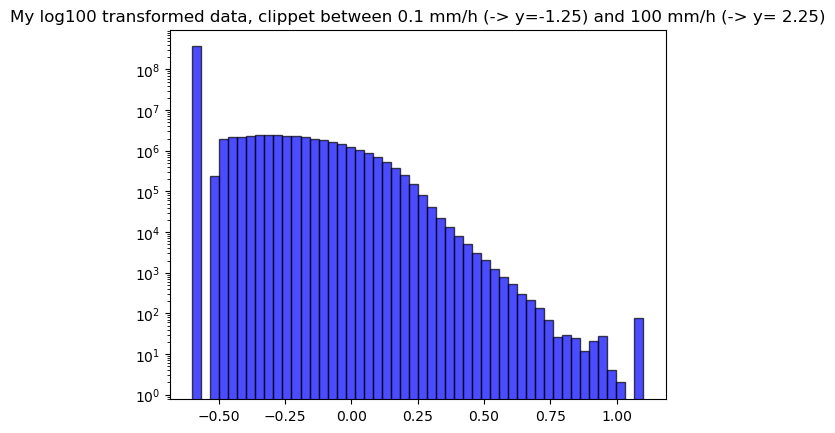

Min val imn data_plotting: 0.0


In [209]:
data_normed = log100_clipping(data_unclipped)
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log100 transformed data, clippet between 0.1 mm/h (-> y=-1.25) and 100 mm/h (-> y= 2.25)')
plt.show()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')


### Easiest to implement approach
Let's just see what happen

### TODO:
look at the bins when doing the binning! Are the bin distances still meaningful?

### log z-normlaization
The log z normalization that we are currently doing is first putting the power-law distributed data into exponentially distributed data
Subsequently the z normalization makes sure that std = 1 and mean = 0. However the range of the input values can still be huge as you can see below

In [190]:
def normalize(data, log_mean, log_std):
    return (np.log1p(data) - log_mean) / log_std

data_normed = normalize(data_plotting, log_mean, log_std)

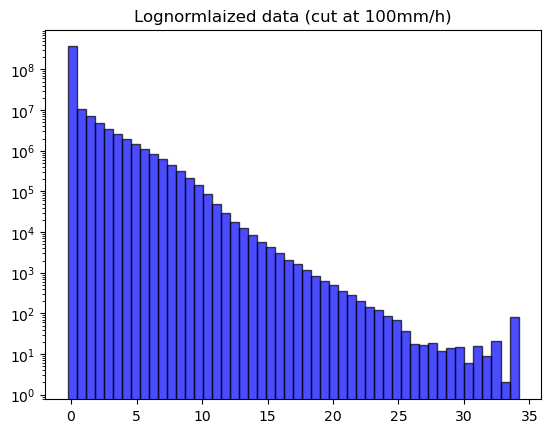

In [191]:
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Lognormlaized data (cut at 100mm/h)')
plt.show()

log10 z-normalization

In [9]:
def log10_normalize(data, log_mean, log_std):
    return (np.log10(data+1) - log_mean) / log_std

data_normed = log10_normalize(data_plotting, log_mean, log_std)

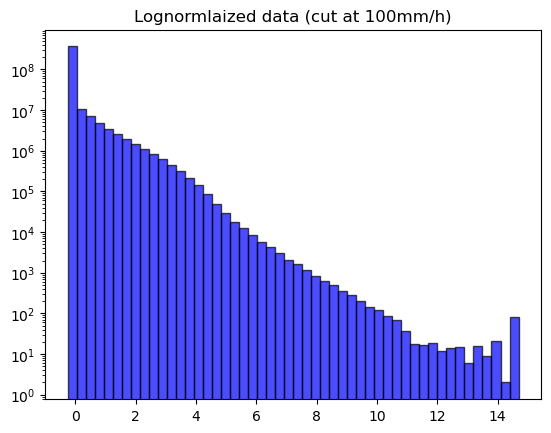

In [10]:
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Lognormlaized data (cut at 100mm/h)')
plt.show()

log100 z-normlaiztion

In [222]:
def log100_normalize(data, log_mean, log_std):
    return ((np.log(data+1)/np.log(100)) - log_mean) / log_std

data_normed = log100_normalize(data_plotting, log_mean, log_std)

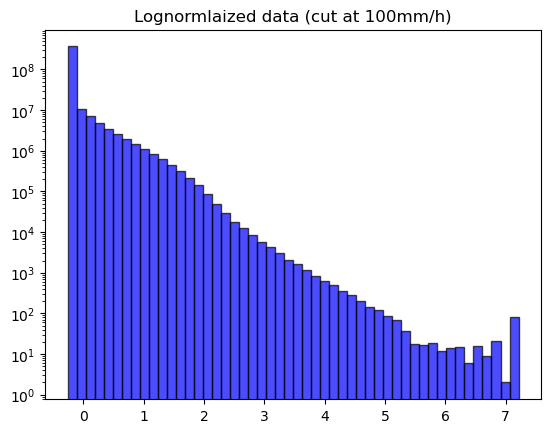

In [223]:
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Lognormlaized data (cut at 100mm/h)')
plt.show()

The main problem with all the above log z-normalizations is that we are taking log(x+1). 
If we want a distribution that is closer to a normal distribution we would need a log that creates negative values such as log(x+0.1) Thsi also means that rain and no rain are really close to each other ( see examples above where this has been done) But choosing the right value to add can be challenging. An alternative is to do the upper and lower bound clipping as shown above

Tan: Simply normalize data between 0 and 1 with tan:
This is probably only good for the input, not for the binning --> Use different normalizations for input and binning!

In [33]:
def tanh_log_normalisierung(x):
    x = np.log10(x+0.1) # First do log10 + 0.1 (see upper) to get nice lognorm distribution 
    x = x+1 #As we added 0.1 our samlles value is -1 in the distribution, therefore +1 to make smalles value (zero rain) zero
    x = np.tanh(x) #TanH to have all values between 0 and 1. Close to zero the tanh is almost linear, but then compresses the large values
    return x

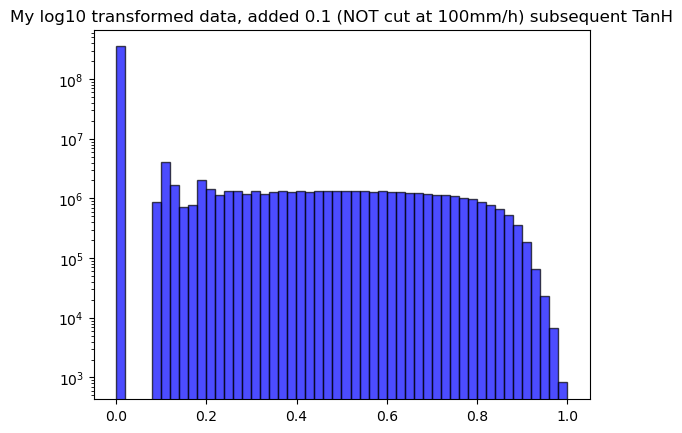

Min val in data_plotting: 0.0


In [35]:
data_normed = tanh_log_normalisierung(data)
data_normed_flattened = data_normed.flatten()
plt.hist(data_normed_flattened[~np.isnan(data_normed_flattened)], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('My log10 transformed data, added 0.1 (NOT cut at 100mm/h) subsequent TanH')
plt.show()
print(f'Min val in data_plotting: {np.nanmin(data_plotting)}')

### So machen wie in Ravuri et al Skilful precipitation nowcasting ...


P. 38 on ArXiv Article
I can also just feed in the one hot channels directly. the Conv 1x1 embedding layer will subsequently transform the one hot encoding into a vector representation